In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd /Volumes/Data/Stanford/telemedicine/telederm-quality/

/Volumes/Data/Stanford/telemedicine/telederm-quality


In [3]:
import pandas as pd
from torchvision.datasets import ImageFolder
import yaml


import sys
paths = ["src"]
for path in paths:
    if path not in sys.path:
        sys.path.append(path)
    
from utils import *
from segmentation import load_skin_segmentation, load_lesion_segmentation
from detect_quality import load_quality_detectors
import seaborn as sns


Bad key "text.kerning_factor" on line 4 in
/Users/kailasv/miniconda3/envs/telederm/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [4]:
class DermImages2(ImageFolder):
    def __init__(self, path_to_images, transform=None, transform_target=None, return_path=False):
        super().__init__(path_to_images, loader=lambda x: x)
        self.num_classes = len(self.classes)
        
        # -- Store transform and label transform functions --
        self.set_transform(transform)
        self.set_target_transform(transform_target)
        
        # -- Return the image path? --
        self.set_return_path(return_path)
        
    def __len__(self):
        return super().__len__()

    def __getitem__(self, idx):   
        # -- Load image (PIL) and label (int) --
        im_path, [im, target] = self.imgs[idx][0], super().__getitem__(idx)
        im = default_loader(im_path)
        # -- Apply transforms --
        if self._transform:
            im = self._transform(im)
        if self._target_transform:
            target = self._target_transform(target)
        ret_vals = [im, target]
        if self.return_im_path:
            ret_vals.append(im_path)
        return tuple(ret_vals)
    
    def set_transform(self, transform):
        self._transform = transform
        
    def set_target_transform(self, target_transform):
        self._target_transform = target_transform
        
    def set_return_path(self, return_path):
        self.return_im_path = return_path

def find_image(file_name, dataset):
    for i, im in enumerate(dataset.imgs):
        if file_name in im[0]:
            return im
        
image_scores = to_numpy(pd.read_excel("data/Labeled_images.xlsx", header=None))
derm_images = DermImages2("../datasets/acne_stanford/data/")
def excel_idx(idx):
    excel = image_scores[idx]
    return find_image(excel[0], derm_images), excel


In [5]:
def main(args):

    def process_im(im, plot_mask=True):
        """Processes and analyzes a single image.""" 
        skin_mask = args.skin_segmentation(im)
        lesion_mask = args.lesion_segmentation(im, skin_mask)
        quality_scores = {k:q(im,skin_mask,lesion_mask) for k,q in args.quality_detectors.items()}
        quality_decisions = {k:q.decide(quality_scores) for k,q in args.quality_detectors.items()}

        im = display_tensor_im(im)
        if plot_mask:
            skin_mask = im*display_tensor_im(skin_mask)
            lesion_mask = im*display_tensor_im(lesion_mask)

        # -- Return values for display --
        return quality_scores, to_numpy(im), to_numpy(skin_mask), to_numpy(lesion_mask)

    for im, im_path in load_images(args):
        quality_scores, im, skin_mask, lesion_mask = process_im(im)
        return quality_scores

In [6]:
config = 'config.yaml'
with open(config, 'r') as f:
    config = yaml.load(f)
config['use_gradio'] = False
config['path_to_images'] = ''
args = Bunch(config)
set_seeds(args.seed)

args.skin_segmentation = load_skin_segmentation(args)
args.lesion_segmentation = load_lesion_segmentation(args)
args.quality_detectors = load_quality_detectors(args)

/Users/kailasv/miniconda3/envs/telederm/lib/python3.7/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
args.path_to_images = excel_idx(0)[0][0]
main(args)

{'blur': -0.6490042175469327,
 'lighting': (0.9843786666666666, 1.0),
 'zoom': 0.999616}

In [8]:
excel_idx(0)[0]

('../datasets/acne_stanford/data/2/gallery_125342_11319_75581.jpg', 2)

In [9]:
im_analysis = []
im_gt = []
for i in range(len(image_scores)):
    print(i, end="..")
    im, meta = excel_idx(i)
    args.path_to_images = im[0]
    im_analysis.append(main(args))
    im_gt.append({k:k in meta[-1] for k in ['blur', 'lighting', 'zoom']})

0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..70..71..

In [10]:
idxs = {'good':[],'blur':[],'lighting':[],'zoom':[]}
for i,h in enumerate(im_gt):
    for k,v in h.items():
        if v: 
            idxs[k].append(i)
    if not any(h.values()):
        idxs['good'].append(i)

In [12]:
im_analysis

[{'blur': -0.6490042175469327,
  'lighting': (0.9843786666666666, 1.0),
  'zoom': 0.999616},
 {'blur': 13.11568193860265,
  'lighting': (0.846616124260355, 1.0),
  'zoom': 0.9845136834319527},
 {'blur': -18.621886012589357, 'lighting': (1.0, 1.0), 'zoom': 1.0},
 {'blur': -2.459785158559213, 'lighting': (1.0, 1.0), 'zoom': 1.0},
 {'blur': 21.556681209247536,
  'lighting': (1.0, 0.9955397489539749),
  'zoom': 1.0},
 {'blur': 2.4305615765239907,
  'lighting': (0.8245706666666667, 0.999984),
  'zoom': 0.792128},
 {'blur': 3.900553556538188,
  'lighting': (0.989406779661017, 0.9998446327683616),
  'zoom': 0.9968079096045198},
 {'blur': 5.366834875580782,
  'lighting': (0.9999887323943661, 0.9999774647887324),
  'zoom': 0.9999830985915493},
 {'blur': -2.8267577188732727,
  'lighting': (1.0, 1.0),
  'zoom': 0.9865212765957447},
 {'blur': 6.3857712354489085,
  'lighting': (0.9918293333333333, 0.914192),
  'zoom': 0.797904},
 {'blur': -4.187000737500633, 'lighting': (1.0, 1.0), 'zoom': 1.0},
 {

blur


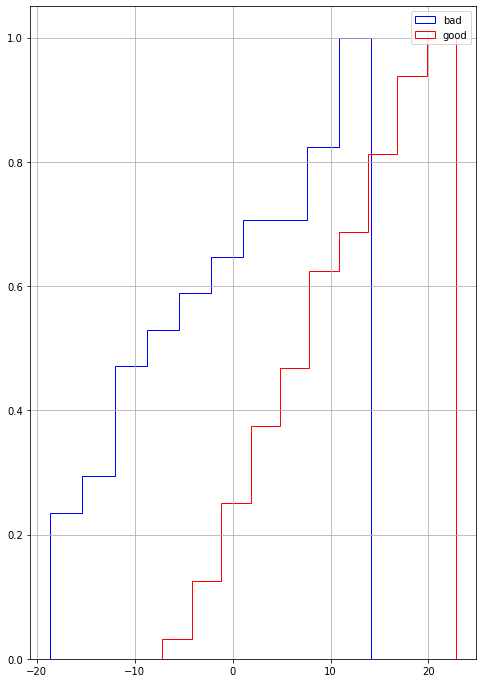

lighting


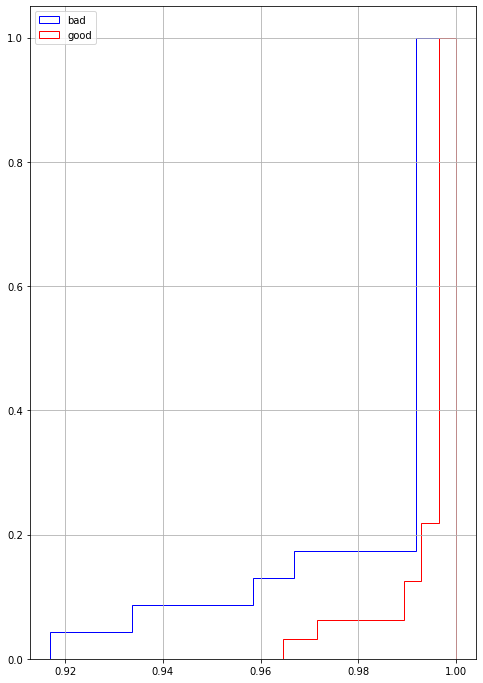

zoom


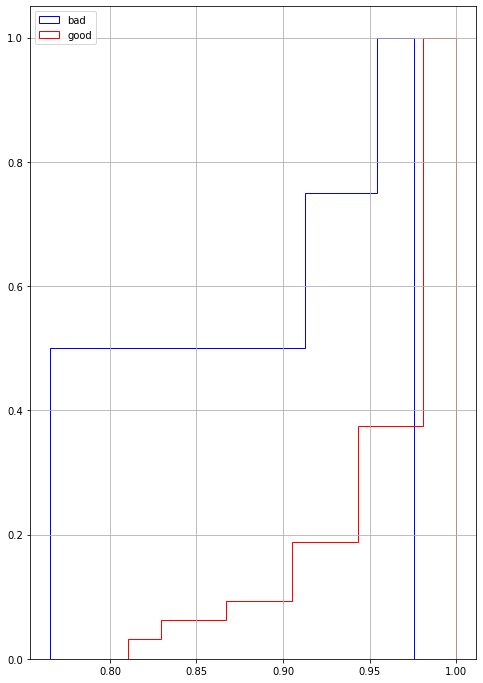

In [16]:
for k in ['blur', 'lighting', 'zoom']:
    print(k, flush=True)
    plt.figure(figsize=(8,12))
    plt.hist([np.max(a[k]) for i,a in enumerate(im_analysis) if i in idxs[k]], 
             color='blue', label='bad', density=True, cumulative=True, histtype='step')
    plt.hist([np.max(a[k]) for i,a in enumerate(im_analysis) if i in idxs['good']], 
             color='red', label='good', density=True, cumulative=True, histtype='step')
    plt.legend()
    plt.grid()
    plt.plot()
    plt.show()

In [17]:
#sns.pairplot(pd.DataFrame(im_analysis))

In [37]:
def make_list(v):
    try: return list(v)
    except: return [v]

In [96]:
simple_dataset = np.array(pd.DataFrame([{f"{k}-{j}":vi for k,v in i.items() for j,vi in enumerate(make_list(v))} 
                                        for i in im_analysis]))
labels = np.array([1 if not any(i.values()) else 0 for i in im_gt])

In [97]:
simple_dataset = np.concatenate((simple_dataset, np.random.rand(len(simple_dataset), 5)), axis=-1)

In [98]:
simple_dataset[0]

array([-0.64900422,  0.98437867,  1.        ,  0.999616  ,  0.44401157,
        0.57482544,  0.26053405,  0.59065911,  0.68808211])

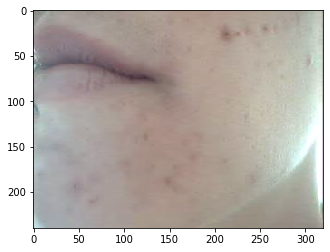

{'blur': -4.187000737500633, 'lighting': (1.0, 1.0), 'zoom': 1.0}
{'blur': True, 'lighting': False, 'zoom': False}


In [99]:
idx=10
plt.imshow(load_image(excel_idx(idx)[0][0]))
plt.show()
print(im_analysis[idx])
print(im_gt[idx])

In [100]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000, penalty='none').fit(simple_dataset, labels)

In [101]:
lr

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [102]:
hat = lr.predict(simple_dataset)

In [103]:
np.sum(hat == labels) / len(labels)

0.75